In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import time
from fredapi import Fred

plt.style.use('fivethirtyeight')
pd.set_option("display.max_columns", 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fred_key = ""

with open('./.apikey', 'r') as file:
    fred_key = file.readline()
fred = Fred(api_key=fred_key)

In [2]:
cpi = fred.search('CPIAUCSL', order_by='popularity')
cpi

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
CPIAUCSL,CPIAUCSL,2023-11-09,2023-11-09,Consumer Price Index for All Urban Consumers: ...,1947-01-01,2023-09-01,Monthly,M,Index 1982-1984=100,Index 1982-1984=100,Seasonally Adjusted,SA,2023-10-12 07:40:02-05:00,93,The Consumer Price Index for All Urban Consume...
RRSFS,RRSFS,2023-11-09,2023-11-09,Advance Real Retail and Food Services Sales,1992-01-01,2023-09-01,Monthly,M,Millions of 1982-84 CPI Adjusted Dollars,Mil. of 1982-84 CPI Adjusted $,Seasonally Adjusted,SA,2023-10-17 07:39:01-05:00,60,The data in this series are calculated using t...
MZMREAL,MZMREAL,2023-11-09,2023-11-09,Real MZM Money Stock (DISCONTINUED),1959-01-01,2021-01-01,Monthly,M,Billions of 1982-84 Dollars,Bil. of 1982-84 $,Seasonally Adjusted,SA,2023-07-26 16:05:01-05:00,2,This series has been discontinued and will no ...
AMBSLREAL,AMBSLREAL,2023-11-09,2023-11-09,Real St. Louis Adjusted Monetary Base (DISCONT...,1947-01-01,2019-11-01,Monthly,M,Billions of 1982-84 Dollars,Bil. of 1982-84 $,Seasonally Adjusted,SA,2020-03-11 13:03:01-05:00,1,This series deflates St. Louis Adjusted Moneta...


In [5]:
from datetime import datetime
now = datetime.now()
lastmonthdate = f"{now.year-10}-{1}"
lastmonthdate

'2013-1'

In [6]:
cpi_series = fred.get_series(series_id='CPIAUCSL', observation_start=lastmonthdate)

In [9]:
df_cpi = cpi_series.reset_index()
df_cpi.columns = ['Date', 'Value']
df_cpi

,Date,Value
0,2013-01-01,231.679
1,2013-02-01,232.937
2,2013-03-01,232.282
3,2013-04-01,231.797
4,2013-05-01,231.893
...,...,...
124,2023-05-01,303.294
125,2023-06-01,303.841
126,2023-07-01,304.348
127,2023-08-01,306.269


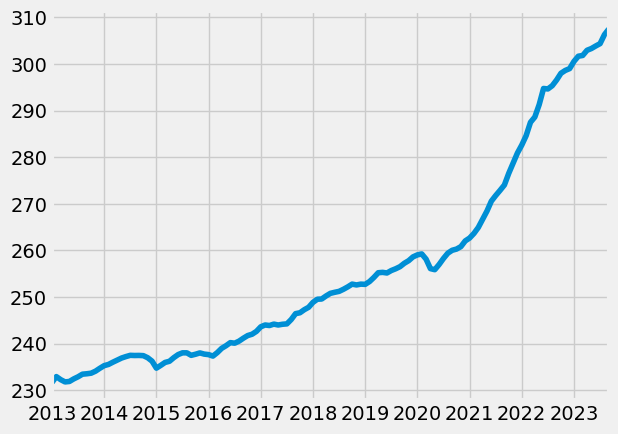

In [50]:
cpi_series.plot();

In [52]:
diff_series = cpi_series.diff()

<AxesSubplot: >

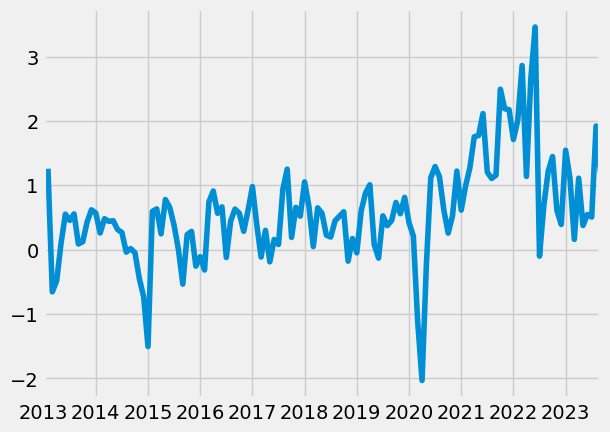

In [53]:
diff_series.plot()

In [1]:
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import datetime
import os

"""
    "CL=F": "Crude Oil",
    "HO=F": "Heating Oil",
    "NG=F": "Natural Gas",
    "RB=F": "RBOB Gasoline",
    "BZ=F": "Brent Crude Oil",
"""

tickers_names = { 
                  "GC=F": "Gold",
                  "SI=F": "Silver",
                  "HG=F": "Copper",
                  "PA=F": "Palladium",
                  "PL=F": "Platinum"
                  }

# 1. Function to fetch data for a given ticker symbol and commodity name
def fetch_data(ticker_symbol, commodity_name):
    ticker = yf.Ticker(ticker_symbol)
    today = datetime.date.today().strftime('%Y-%m-%d')
    data = ticker.history(start="2013-01-01", end=today)
    data.reset_index(inplace=True)
    
    # Check if the 'Date' column is of datetime type
    if pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
    
    # Drop the unnecessary columns
    data.drop(columns=['Dividends', 'Stock Splits', 'Adj Close'], inplace=True, errors='ignore')
    
    data['ticker'] = ticker_symbol  
    data['commodity'] = commodity_name  
    
    # Convert other column names to lowercase
    data.columns = [col.lower() for col in data.columns]
    
    # Reorder columns to have 'ticker' and 'commodity' at the beginning
    data = data[['ticker', 'commodity'] + [col for col in data.columns if col not in ['ticker', 'commodity']]]
    
    return data


# 2. Loop over each symbol and append data to the master DataFrame
all_data = []
for symbol, name in tqdm(tickers_names.items(), desc="Fetching data"):  # tqdm progress bar!
    all_data.append(fetch_data(symbol, name))

# Concatenate all the individual datasets into one
master_data = pd.concat(all_data, ignore_index=True)

Fetching data: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


In [2]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13613 entries, 0 to 13612
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ticker     13613 non-null  object 
 1   commodity  13613 non-null  object 
 2   date       13613 non-null  object 
 3   open       13613 non-null  float64
 4   high       13613 non-null  float64
 5   low        13613 non-null  float64
 6   close      13613 non-null  float64
 7   volume     13613 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 850.9+ KB


In [3]:
# 1. Save the master DataFrame as a CSV
master_data.to_csv('all_metals_data.csv', index=False)

# 2. Save individual CSVs for each index

# Create a directory in the output to store individual datasets
output_dir = 'individual_data'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

for symbol, name in tqdm(tickers_names.items(), desc="Saving individual datasets"):  # tqdm progress bar!
    single_data = fetch_data(symbol, name)
    # Drop the 'ticker' and 'commodity' columns if they exist
    if 'ticker' in single_data.columns:
        single_data.drop('ticker', axis=1, inplace=True)
    if 'commodity' in single_data.columns:
        single_data.drop('commodity', axis=1, inplace=True)
    
    # Use the commodity name for the filename, replacing any special characters
    safe_name = name.replace(" ", "_").replace("/", "_").replace("\\", "_")
    
    single_data.to_csv(f'{output_dir}/{safe_name}_data.csv', index=False)

Saving individual datasets: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
